In this week's tutorial we will look into generative modelling. At the end of this tutorial you should be able to:
- Build a variational auto-encoder
- Use it to generate images

# Building a variational auto-encoder

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim, hidden_dims=None):
        super().__init__() # we need this so it inherits everything from the class nn
        self.latent_dim = latent_dim

        # Build encoder; it is standard for the encoder's number of channels to increase
        modules = []
        if hidden_dims is None: # define a certain number  configuration for the encoder
            hidden_dims = [32, 64, 128, 256, 512]
        
        for h_dim in hidden_dims: 
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size = 3, stride = 2, padding = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim 
        
        # the encoder consist of the list modules which is len(hidden_dims) times the sequence 
        # we defined above in nn.Sequential
        self.encoder = nn.Sequential(*modules)
        # now we will define the mu and sigma layers (remember: encoder maps our x into mu and sigma (=\psi)
        # which will be the input for our q_{\psi}(z|x) to sample z)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim) 
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        
        # Build decoder (takes as input z of dimensionality latent_dim)
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        hidden_dims.reverse() # same structure as hidden_dims but other way around
        
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], # this is a deconvolution layer
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        
        self.decoder = nn.Sequential(*modules)
        # final layer then computes tanh(something); this is the mu and we assume sigma=Identity
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
    
    def encode(self, input):
        """ 
        Encodes the input by passing it through the encoder network and returning z (the latent variable) in list form
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1) # only dimensions starting with start_dim are flattened
        # Split the result into mu and var; each of dimension latent_dim
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]
        
    def decode(self, z): # this is in essense a single sample from p_{\theta}(x|z)=Gaussian(output,I)
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2) # we need this to change z to the right dimensions for conv layers
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def reparametrize(self, mu, var):
        """
        does the reparametrizatrion trick
        """
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparametrize(mu, log_var) # sample a random z
        return [self.decode(z), input, mu, log_var]
    
    def loss_function(self, *args):
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        recons_loss =F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        return recons_loss + 0.0001*kld_loss
        
    def sample(self, num_samples):
        """
        Samples from the latent space and returns the corresponding input (basically just passing through decoder)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        samples = self.decode(z)
        return samples


Let's now load the data that we will use. Make sure you have a folder called data_faces in your working directory. Only do the below once! 

In [ ]:
# Load data
import os
from urllib.request import urlretrieve
fullfilename = os.path.join('./data_faces/', 'celeba')
urlretrieve("https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip ", fullfilename)

In [ ]:
import zipfile

with zipfile.ZipFile("./data_faces/celeba","r") as zip_ref:
    zip_ref.extractall("data_faces/")

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

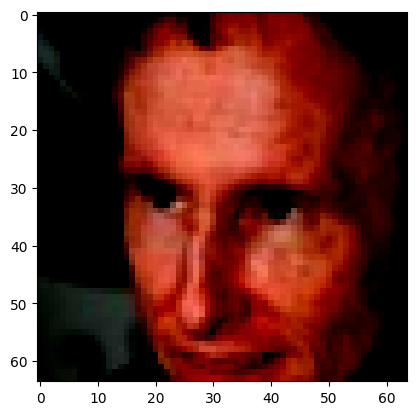

In [6]:
# Crop and scale the data
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Resize(size=(re_size, re_size)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64
celeba_data = torchvision.datasets.ImageFolder('./data_faces/', transform=transform)
data_loader = torch.utils.data.DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

dataiter = iter(data_loader)
img, labels = dataiter.next()
plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))
plt.plot()

In [7]:
# Train the model 
epochs = 1
in_channels = 3
latent_dim = 100
vae = VAE(in_channels=in_channels, latent_dim=latent_dim)

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

step = 0
losses = []
for epoch in range(epochs):
    for idx, (img_batch, _) in enumerate(data_loader):
        step += 1
        mbatch_size = img_batch.size()[0]
        # forward pass 
        [a,b,c,d] = vae.forward(img_batch)
        loss = vae.loss_function(a,b,c,d)
        # Zero out the gradients
        optimizer.zero_grad()
        # Compute the gradients
        loss.backward()
        # Take the optimisation step
        optimizer.step()

        # print statistics
        losses += [loss.item()]
        if step % 10 == 0:    # print every 100 iterations
            print(step, loss.item())

print('Finished Training')

10 0.1902775764465332
20 0.15360277891159058
30 0.12031059712171555
40 0.10901151597499847
50 0.09738405793905258
60 0.09099336713552475
70 0.09261454641819
80 0.08865704387426376
90 0.09010995179414749
100 0.07767108827829361
110 0.07958345860242844
120 0.07709092646837234
130 0.0742955282330513
140 0.0743589997291565
150 0.07185989618301392
160 0.07958294451236725
170 0.07420503348112106
180 0.0679461658000946
190 0.06136636808514595
200 0.0755239725112915
210 0.06558844447135925
220 0.06486291438341141
230 0.056507907807826996
240 0.06305504590272903
250 0.0653376430273056
260 0.06216477230191231
270 0.060608651489019394
280 0.05910765752196312
290 0.05742986127734184
300 0.05973270535469055
310 0.06538259983062744
320 0.057671066373586655
330 0.0561523400247097
340 0.05705289542675018
350 0.05780426040291786
360 0.053039249032735825
370 0.059243712574243546
380 0.052935510873794556
390 0.0552026741206646
400 0.05702530965209007
410 0.057157739996910095
420 0.05670110136270523
430 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 3, 64, 64)


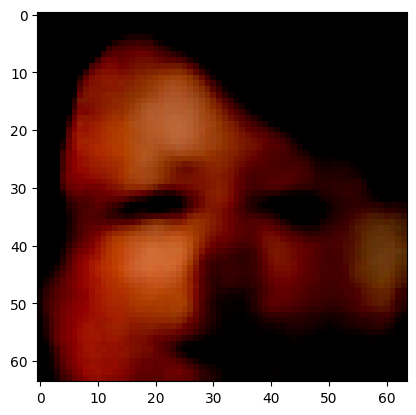

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


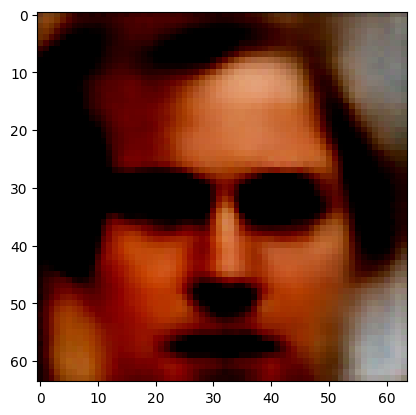

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


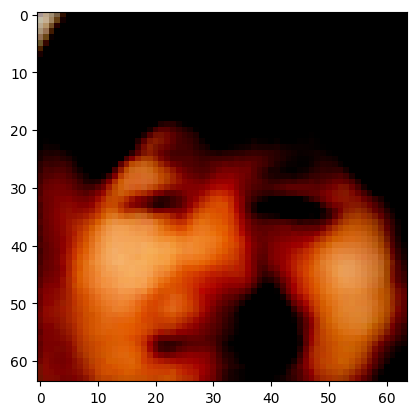

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


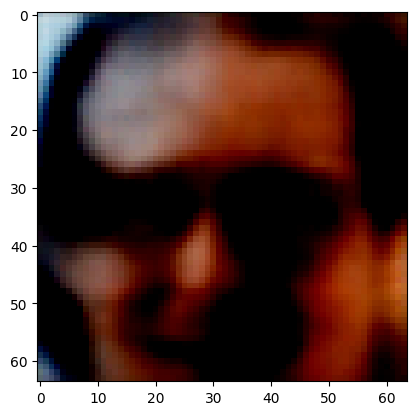

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


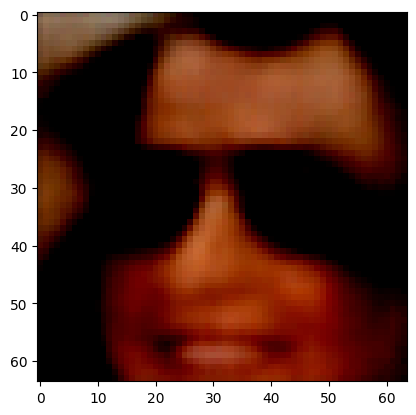

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


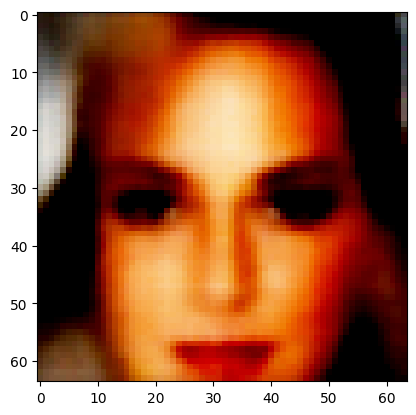

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


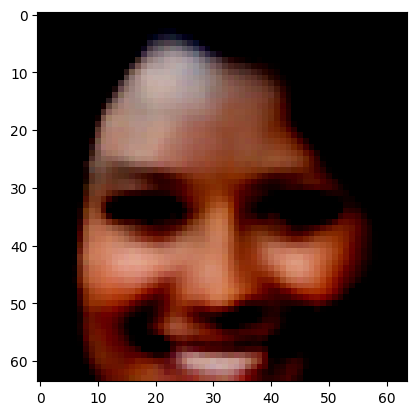

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


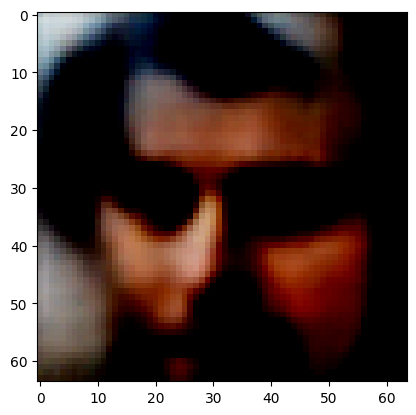

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


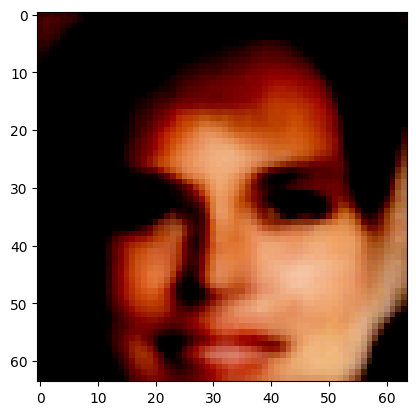

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


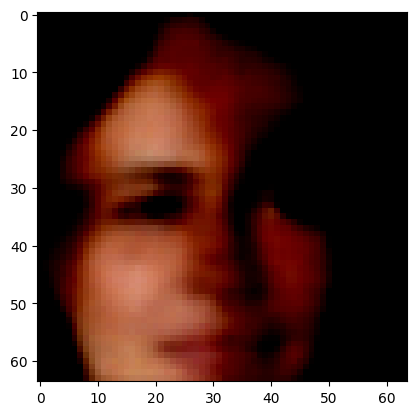

In [12]:
# Sample 
num_samples = 10
outputs = vae.sample(num_samples)
numpy_outputs = outputs.detach().numpy()
print(numpy_outputs.shape)
for it in range(num_samples):
    plt.imshow(np.transpose(numpy_outputs[it], (1, 2, 0)))
    plt.show()

Play around with the following: 
- The parameters in the loss function (when putting too much weight on the KL term, all faces look the same)
- The optimisation method
- The number of epochs
- The architecture of the model. 